In [1]:
import gym

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 100 steps (frames) of one episode

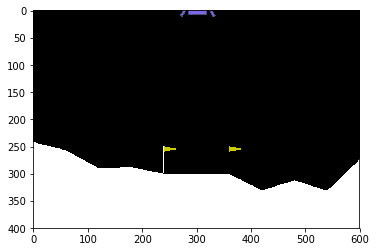

In [2]:
env = gym.make('LunarLander-v2')
# env.render()
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

In [3]:
from time import sleep

for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
    # sleep(0.1)
    
print 'Simulation finished'

Simulation finished


<Figure size 432x288 with 0 Axes>

# 2. Run a training process

In [4]:
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

Using TensorFlow backend.


In [5]:
import numpy as np
env = gym.make('LunarLander-v2')
env.seed(0)
np.random.seed(0)

In [6]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Average score of last 100 episode
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

In [ ]:
if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 400
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
    plt.show()

Box(8,)
Discrete(4)

episode: 0/400, score: -130.282375017
Average over last 100 episode: -130.28 

episode: 1/400, score: -44.1590847225
Average over last 100 episode: -87.22 

episode: 2/400, score: -273.133245234
Average over last 100 episode: -149.19 

episode: 3/400, score: -131.229418953
Average over last 100 episode: -144.70 

episode: 4/400, score: -254.79938886
Average over last 100 episode: -166.72 

episode: 5/400, score: -158.297363623
Average over last 100 episode: -165.32 

episode: 6/400, score: -53.9282125416
Average over last 100 episode: -149.40 

episode: 7/400, score: -428.280246208
Average over last 100 episode: -184.26 

episode: 8/400, score: -24.2461627188
Average over last 100 episode: -166.48 

